In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, BatchNormalization, ReLU
from keras.layers import Dropout, Dense, TimeDistributed, Reshape, Bidirectional
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
!pip install --upgrade scikit-learn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

2024-04-13 04:48:10.504686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 04:48:10.504811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 04:48:10.630111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 81.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 32
N_CLASSES = 7

In [3]:
# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             directory='/kaggle/input/ravdess-full/RAVDESS/Mel_Spectrograms/Train',
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             directory='/kaggle/input/ravdess-full/RAVDESS/Mel_Spectrograms/Test',
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

Found 3976 files belonging to 7 classes.
Found 254 files belonging to 7 classes.


In [4]:
def get_crnnd_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation = 'relu', strides = (1, 1), padding = 'same', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation = 'relu', strides = (1, 1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation = 'relu', strides = (1, 1), padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(Reshape((-1, 128)))
  model.add(LSTM(128, dropout=0.5, return_sequences=True))
  model.add(LSTM(128, dropout=0.5, return_sequences=True))
  model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(256, activation='relu')))
  model.add(TimeDistributed(Dense(128, activation='relu')))
  model.add(TimeDistributed(Dense(64, activation='relu')))
  model.add(Flatten())
  model.add(Dense(7, activation = 'softmax'))
  model.summary()
  model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001), metrics = ['acc'])
  return model

In [ ]:
model_name = 'CRNN'
model = get_crnnd_model()

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [7]:
# history = model.fit(train_dataset, epochs = 50, batch_size = 32, validation_data=valid_dataset, callbacks = [early_stopping], verbose = 1)
history = model.fit(train_dataset, epochs = 50, batch_size = 32, validation_data=valid_dataset, verbose = 1)

Epoch 1/50


2024-04-13 04:48:46.113057: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2175: 3.31527, expected 2.86333
2024-04-13 04:48:46.113147: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8832: 3.04387, expected 2.59193
2024-04-13 04:48:46.113167: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8960: 3.285, expected 2.83305
2024-04-13 04:48:46.113180: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9600: 3.16471, expected 2.71277
2024-04-13 04:48:46.113200: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12032: 3.08921, expected 2.63726
2024-04-13 04:48:46.113225: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15360: 3.30205, expected 2.8501
2024-04-13 04:48:46.113329: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 4.65504, expected 3.81534
2024-04-13 04:48:46.113349: E exte

  3/125 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - acc: 0.1233 - loss: 3.5854 

I0000 00:00:1712983730.341742      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - acc: 0.2143 - loss: 2.5612

2024-04-13 04:49:00.807015: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.19276, expected 3.38235
2024-04-13 04:49:00.807088: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.49174, expected 4.68133
2024-04-13 04:49:00.807105: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.83728, expected 5.02687
2024-04-13 04:49:00.807124: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.14363, expected 4.33322
2024-04-13 04:49:00.807137: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.75173, expected 3.94132
2024-04-13 04:49:00.807148: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.04628, expected 4.23587
2024-04-13 04:49:00.807160: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.21611, expected 3.40569
2024-04-13 04:49:00.807171: E external/local_xla/xla/se

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - acc: 0.2149 - loss: 2.5566

2024-04-13 04:49:05.421620: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49091: 2.68041, expected 2.29747
2024-04-13 04:49:05.421679: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49092: 2.67849, expected 2.29555
2024-04-13 04:49:05.421689: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49151: 2.47575, expected 2.09282
2024-04-13 04:49:05.421697: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49152: 3.67213, expected 2.80566
2024-04-13 04:49:05.421705: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49153: 5.58959, expected 4.72311
2024-04-13 04:49:05.421713: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49154: 5.4633, expected 4.59683
2024-04-13 04:49:05.421720: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49155: 5.14664, expected 4.28016
2024-04-13 04:49:05.421728: 

125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - acc: 0.2155 - loss: 2.5520 - val_acc: 0.3189 - val_loss: 1.7917
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - acc: 0.4761 - loss: 1.4218 - val_acc: 0.5197 - val_loss: 1.3277
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - acc: 0.6263 - loss: 1.0517 - val_acc: 0.5157 - val_loss: 1.2317
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - acc: 0.7244 - loss: 0.7880 - val_acc: 0.6890 - val_loss: 0.8568
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - acc: 0.8017 - loss: 0.5563 - val_acc: 0.6890 - val_loss: 0.8949
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - acc: 0.8727 - loss: 0.3997 - val_acc: 0.7205 - val_loss: 0.8317
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - acc: 0.9007 - loss: 0.3283 - val_acc: 0.7402 - val_loss: 0.7982
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - acc: 0.9101 - loss: 0.2759 - val_acc: 0.7717 - val_loss: 0.6900
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - ac

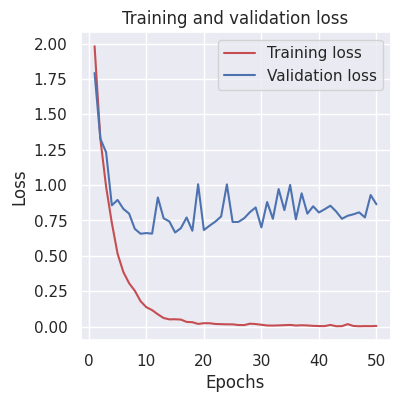

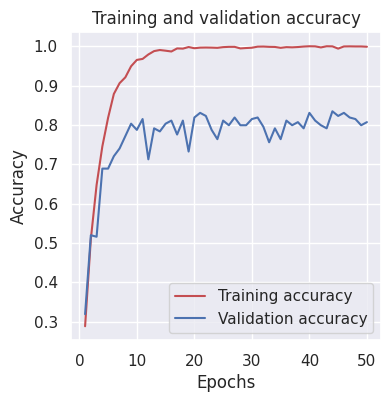

Final loss: 0.000244, final accuracy: 1.000000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
              precision    recall  f1-score   support

       Anger       0.82      0.82      0.82        39
     Disgust       0.90      0.95      0.92        39
        Fear       0.79      0.85      0.81        39
       Happy       0.79      0.49      0.60        39
     Neutral       0.79      0.75      0.77        20
         Sad       0.69      0.85      0.76        39
    Surprise       0.88      0.92      0.90        39

    accuracy                           0.81       254
   macro avg       0.81      0.80      0.80       254
weighted avg       0.81      0.81      0.80       254



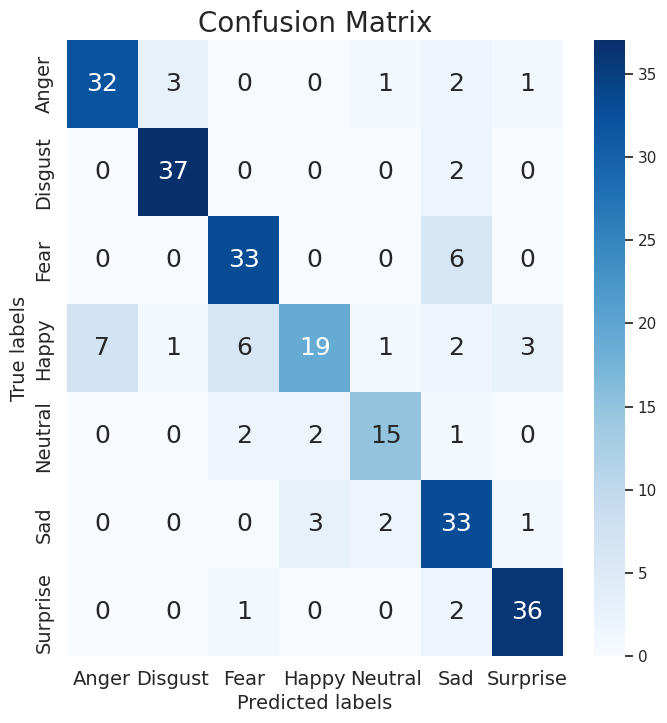

In [10]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)
    
plt.figure(figsize=(4,4))
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves for training and validation.
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(4,4))
plt.plot(epochs, acc_values, 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(train_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming `test_dataset` contains your test data and labels, and `model` is your trained Keras model
test_images = []
test_labels = []
for images, labels in valid_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Get model predictions on the test data
y_pred = np.argmax(model.predict(test_images), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)
class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(test_labels, y_pred, target_names=class_names)

# Print the classification report
print('Classification Report:')
print(report)

# Define the class labels
class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Plot the confusion matrix using Seaborn's heatmap function
sns.set()
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues', annot_kws={"fontsize": 18}, xticklabels=class_names, yticklabels=class_names)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted labels', size=14)
plt.ylabel('True labels', size=14)
plt.show()